In [1]:
# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# import Array and set default backend
from qiskit_dynamics.array import Array
Array.set_default_backend('jax')

/Users/arthurstrauss/opt/anaconda3/envs/qiskit_env/lib/python3.9/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
from qiskit import pulse
from qiskit_dynamics.pulse import InstructionToSignals
import sympy as sym

dt = 0.222
w = 5.

# Helper function that returns a lifted Gaussian symbolic equation.
def lifted_gaussian(
    t: sym.Symbol,
    center,
    t_zero,
    sigma,
) -> sym.Expr:
    t_shifted = (t - center).expand()
    t_offset = (t_zero - center).expand()

    gauss = sym.exp(-((t_shifted / sigma) ** 2) / 2)
    offset = sym.exp(-((t_offset / sigma) ** 2) / 2)

    return (gauss - offset) / (1 - offset)

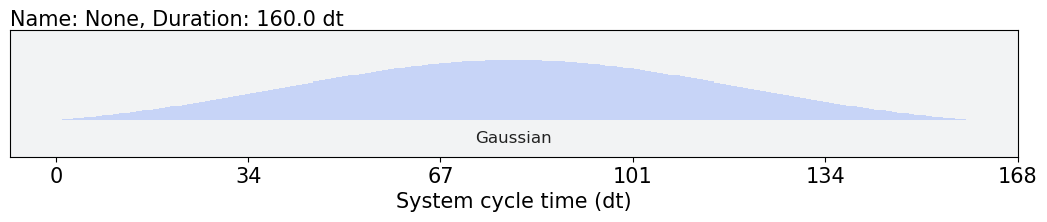

In [3]:
_t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
_center = _duration / 2

envelope_expr = (
    _amp * sym.exp(sym.I * _angle) * lifted_gaussian(_t, _center, _duration + 1, _sigma)
)

gaussian_pulse = pulse.ScalableSymbolicPulse(
        pulse_type="Gaussian",
        duration=160,
        amp=0.3,
        angle=0,
        parameters={"sigma": 40},
        envelope=envelope_expr,
        constraints=_sigma > 0,
        valid_amp_conditions=sym.Abs(_amp) <= 1.0,
    )

gaussian_pulse.draw()

In [4]:
import numpy as np

x_pulse = np.ones(100) * 0.5
amp_0 = 0.4
sigma_0 = int(20.0)

# use amplitude as the function argument
def jit_func(amp, sigma):
    _t, _duration, _amp, _sigma, _angle = sym.symbols("t, duration, amp, sigma, angle")
    _center = _duration / 2

    envelope_expr = (
        _amp * sym.exp(sym.I * _angle) * lifted_gaussian(_t, _center, _duration + 1, _sigma)
    )

    gaussian_pulse = pulse.ScalableSymbolicPulse(
            pulse_type="Gaussian",
            duration=160,
            amp=amp,
            angle=0.5,
            parameters={"sigma": 40},
            envelope=envelope_expr,
            constraints=_sigma > 0,
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )
    
    gaussian_pulse_2 = pulse.ScalableSymbolicPulse(
            pulse_type="Gaussian",
            duration=200,
            amp=amp,
            angle=0,
            parameters={"sigma": sigma},
            envelope=envelope_expr,
            constraints=_sigma > 0,
            valid_amp_conditions=sym.Abs(_amp) <= 1.0,
        )

    # build a pulse schedule
    with pulse.build() as schedule:
        pulse.shift_frequency(amp, pulse.DriveChannel(0))
        pulse.play(gaussian_pulse, pulse.DriveChannel(0))
        pulse.play(gaussian_pulse_2, pulse.DriveChannel(0))
        pulse.play(x_pulse, pulse.DriveChannel(0))

    # convert from a pulse schedule to a list of signals
    converter = InstructionToSignals(dt, carriers={"d0": w})

    return converter.get_signals(schedule)[0].samples.data

jax.jit(jit_func)(amp_0, sigma_0)

j_func = jax.jit(jit_func)
# j_func = jit_func

res = j_func(amp_0, sigma_0)
gate = x_pulse
print(res.shape)
print(res.dtype)
print(res)
alt_arr = np.concatenate((res, gate), axis=0)
print(alt_arr.shape)
print(alt_arr)

(460,)
complex128
[ 4.05129511e-03+2.21323261e-03j  3.84700718e-03+6.83176720e-03j
 -5.04184966e-04+1.11723359e-02j -8.30759108e-03+1.20641990e-02j
 -1.67246975e-02+7.26520299e-03j -2.17046506e-02-3.23909187e-03j
 -1.96165244e-02-1.67279933e-02j -8.98126314e-03-2.83535416e-02j
  8.40862629e-03-3.27686929e-02j  2.75335743e-02-2.62566476e-02j
  4.15132364e-02-8.57590616e-03j  4.39520179e-02+1.62547608e-02j
  3.14955008e-02+4.06973802e-02j  5.64707093e-03+5.59038423e-02j
 -2.69505775e-02+5.47710717e-02j -5.60930927e-02+3.48227275e-02j
 -7.11285688e-02-1.68697627e-04j -6.46818380e-02-4.05809599e-02j
 -3.57268497e-02-7.34847670e-02j  9.17321878e-03-8.66966836e-02j
  5.71247318e-02-7.30955731e-02j  9.25207527e-02-3.37188975e-02j
  1.02031971e-01+2.15831514e-02j  7.93995177e-02+7.64396045e-02j
  2.83586097e-02+1.12732877e-01j -3.75073536e-02+1.16487125e-01j
 -9.82513157e-02+8.29821035e-02j -1.33541772e-01+1.92819934e-02j
 -1.29364115e-01-5.69266657e-02j -8.32617844e-02-1.22148275e-01j
 -6.228

In [5]:
%timeit j_func(amp_0, sigma_0)

18.2 µs ± 619 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [6]:
import jax.numpy as jnp

t_arr = np.linspace(0.0, 1.0, 100)
x_pulse = np.ones(100) * 0.2
y_pulse = 0.1 * np.exp(-(t_arr - 0.5)**2)
z_pulse = 0.9 * np.exp(-(t_arr - 0.5)**2)

base_pulses = jnp.array([x_pulse, y_pulse, z_pulse])

def make_signals(params, mode):
    gate = base_pulses[mode]
    return jnp.concatenate((j_func(*params), gate), axis=0)

params = np.array([amp_0, sigma_0])
batchsize = 300
big_params = jnp.tile(params, (batchsize, 1))
big_modes = jnp.ones(batchsize, dtype=jnp.int8)

batched_make_signals = jax.jit(jax.vmap(make_signals))

batched_res = batched_make_signals(big_params, big_modes)
print(batched_res.shape)

%timeit batched_make_signals(big_params, big_modes)

(300, 560)
2.05 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
base_pulses_np = np.array([x_pulse, y_pulse, z_pulse])
def vectorize(big_params, big_modes):
    for param, mode in zip(big_params, big_modes):
        gate = base_pulses_np[mode]
        signal = jit_func(*param)
    gate = base_pulses[mode]
    return np.concatenate((jit_func(*params), gate), axis=0)
%timeit vectorize(big_params, big_modes)

3.65 s ± 54 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
